# 3D QLIPP reconstruction with experimental data
This reconstruction is based on the QLIPP paper ([here](https://elifesciences.org/articles/55502)): <br>
``` S.-M. Guo, L.-H. Yeh, J. Folkesson, I. E. Ivanov, A. P. Krishnan, M. G. Keefe, E. Hashemi, D. Shin, B. B. Chhun, N. H. Cho, M. D. Leonetti, M. H. Han, T. J. Nowakowski, S. B. Mehta , "Revealing architectural order with quantitative label-free imaging and deep learning," eLife 9:e55502 (2020).```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import time

import glob
from skimage import io
import waveorder as wo


%matplotlib inline
plt.style.use(['dark_background']) # Plotting option for dark background

### Experiment parameters

In [9]:
n_media       = 1.512                   # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu   = 0.532               # illumination wavelength (um)
mag           = 63                  # magnification of the microscope                      
NA_obj        = 1.47                # detection NA of the objective
NA_illu       = 0.9                 # illumination NA of the condenser
N_defocus     = 45                   # number of defocus images
N_channel     = 5                   # number of Polscope channels
z_step        = 0.25               # z_step of the stack
z_defocus     = -(np.r_[:N_defocus]-N_defocus//2)*z_step
pad_z         = 5                  # padding in the z-dimension
chi           = 0.1*2*np.pi        # swing of the LC
ps            = 6.45/mag            # effective pixel size at the sample plane (cam pix/mag in um)
cali          = True                # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option     = 'local_fit'         # background correction method for Polscope recon (does not affect phase)
data_path     = '/gpfs/CompMicro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/SMS_2018_1227_1433_1/2-Pos_007_025/'        # data path
bg_path       = '/gpfs/CompMicro/rawdata/dragonfly/virtualstaining/2019_02_15_kidney_slice/BG_2019_0215_1337_1/Pos0/'           # background data path
use_gpu       = True
gpu_id        = 0

In [10]:
filedir = data_path + '*PolState*.tif'
filedir_bg = bg_path + '*State*.tif'
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

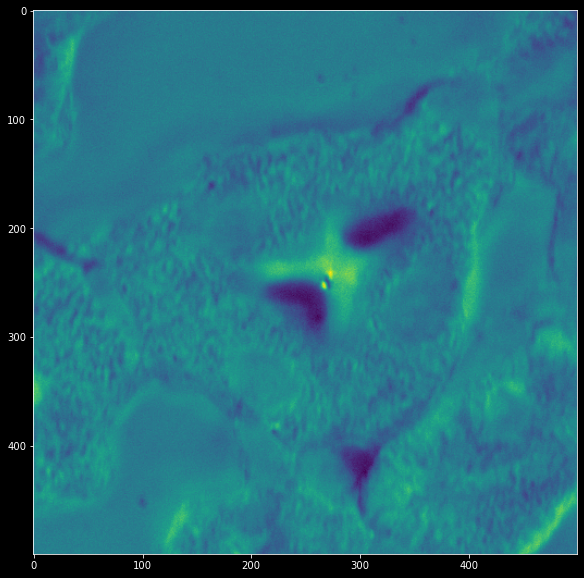

In [11]:
# select a FOV for processing

Ns = 500
Ms = 500
n_start = [500, 1350] 

plt.figure(figsize=(10,10))
plt.imshow(plt.imread(files[44+22]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms])


### Load data

In [6]:
# Load files

Nimg = N_defocus*N_channel

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

I_meas_pre =[]

for i in range(0, Nimg):
    Itemp = io.imread(files[i]).astype('float64')[n_start[0]:n_start[0]+Ns, n_start[1]:n_start[1]+Ms]
    I_meas_pre.append(Itemp)
    
I_meas_pre = np.array(I_meas_pre)
I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0,2,3,1))

# intensity mapping to match the theory
I_meas = np.zeros_like(I_meas_pre)
for i in range(N_defocus):
    I_meas[:,:,:,i] = wo.intensity_mapping(I_meas_pre[:,:,:,i])

In [8]:
wo.parallel_4D_viewer(np.transpose(I_meas,(3,0,1,2)), num_col=5, size=5)

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### Polarization reconstruction

In [19]:
# Reconstruct parameters

setup = wo.waveorder_microscopy((Ns,Ms), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi,\
                                n_media = n_media, cali=cali, bg_option=bg_option, bire_in_plane_deconv='3D',\
                                phase_deconv='3D', pad_z=pad_z, use_gpu=use_gpu, gpu_id=gpu_id)


In [20]:
S_image_recon = setup.Stokes_recon(I_meas)
S_bg_recon = setup.Stokes_recon(I_bg)
S_image_tm = setup.Stokes_transform(S_image_recon)
S_bg_tm = setup.Stokes_transform(S_bg_recon)
S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)  
Recon_para = setup.Polarization_recon(S_image_tm)

In [14]:
wo.parallel_4D_viewer(np.transpose(Recon_para,(3,0,1,2)), num_col=2, size=10)

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

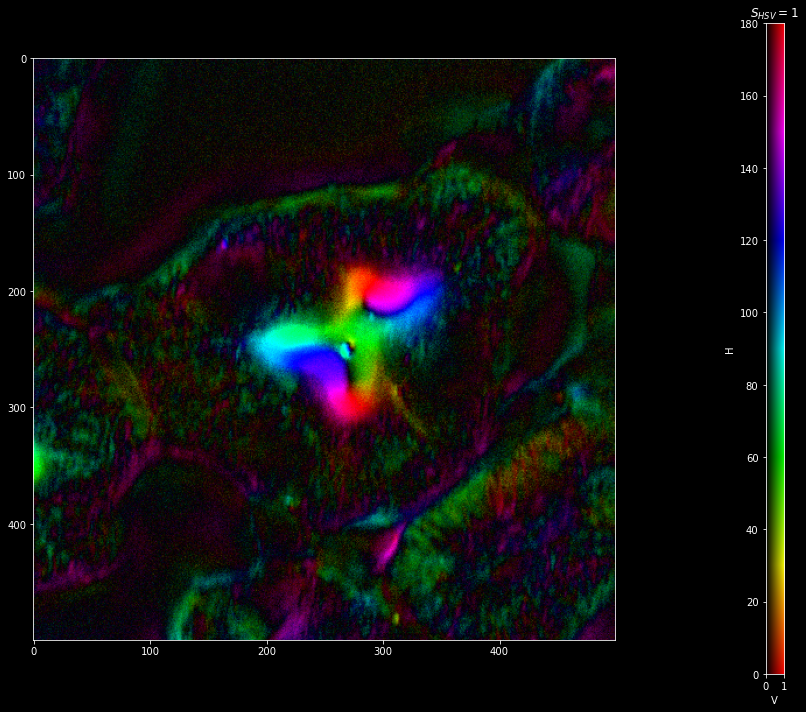

In [30]:
wo.plot_hsv([Recon_para[1,:,:,22], np.clip(Recon_para[0,:,:,22],0,2*np.pi*5e-3/lambda_illu)],max_val=1, size=10)

### Phase reconstruction

In [15]:
phase = setup.Phase_recon_3D(S_image_tm[0], absorption_ratio=0.0, method='Tikhonov', reg_re = 1e-4)


In [16]:
wo.image_stack_viewer(np.clip(np.transpose(phase,(2,0,1)),-0.08, 0.08))

interactive(children=(IntSlider(value=0, description='stack_idx', max=44), Output()), _dom_classes=('widget-in…

<function waveorder.visual.image_stack_viewer.<locals>.interact_plot_3D(stack_idx)>

## Birefringence reconstruction with $S_1$ and $S_2$ 

In [28]:

# The negative sign on S2 here is to compensate the sign convention in the old data format
retardance_deconv, orientation_deconv = setup.Birefringence_recon_3D(S_image_tm[1], -S_image_tm[2], method='Tikhonov', reg_br = 30)

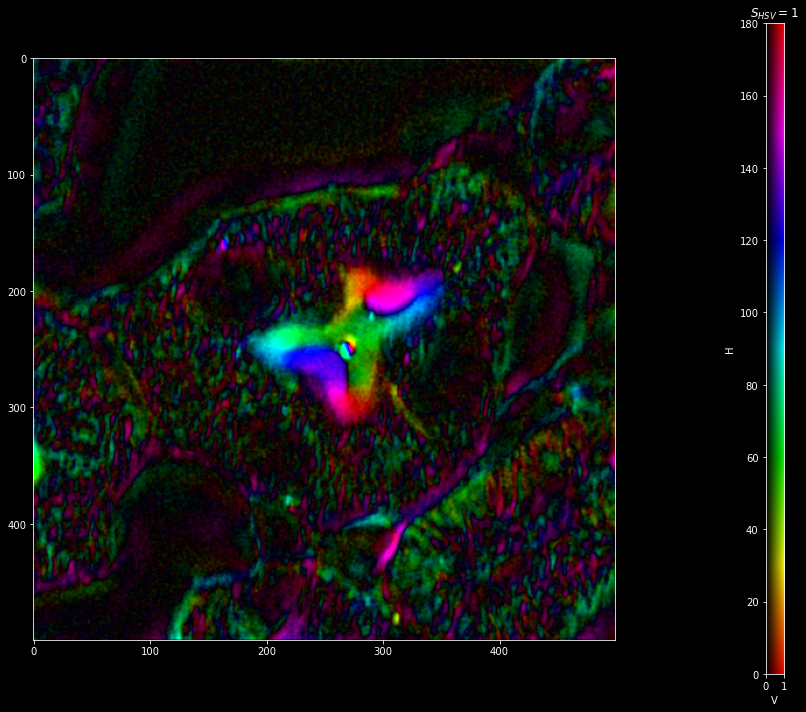

In [29]:
wo.plot_hsv([orientation_deconv[:,:,22], retardance_deconv[:,:,22]], max_val=0.3, size=10)

In [17]:
import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()